# Preliminaries

In [ ]:
# using Gallium -- never mind, can't get this debugger to work properly.  I guess that's why they call it "experimental"!

In [1]:
# import ForwardDiff
using PyCall
# import PyPlot
using PyPlot
using ForwardDiff
using DiffBase
using MAT

pygui(true)

import Base.convert
convert(::Type{Float64}, x::ForwardDiff.Dual) = Float64(x.value)
function convert(::Array{Float64}, x::Array{ForwardDiff.Dual}) 
    y = zeros(size(x)); 
    for i in 1:prod(size(x)) 
        y[i] = convert(Float64, x[i]) 
    end
    return y
end

include("hessian_utils.jl")

"""
We define functions to convert Duals, the variable types used by ForwardDiff, 
to Floats. This is useful if we want to print out the value of a variable 
(since print doesn't know how to Duals). Note that after being converted to a Float, no
differentiation by ForwardDiff can happen!  e.g. after
    x = convert(Float64, y)
ForwardDiff can still differentiate y, but it can't differentiate x
"""




"We define functions to convert Duals, the variable types used by ForwardDiff, \nto Floats. This is useful if we want to print out the value of a variable \n(since print doesn't know how to Duals). Note that after being converted to a Float, no\ndifferentiation by ForwardDiff can happen!  e.g. after\n    x = convert(Float64, y)\nForwardDiff can still differentiate y, but it can't differentiate x\n"

# Main dynamics function

In [2]:
function mgo_dynamics(;cue_period=500, delay_period=1000, response_period=500,
    const_E=15, theta=5, U_rest=-60, U_init=-51, Uth=-50, g_leak=1, response_extra_E=5, 
    nderivs=0, difforder=0, dt=5, tau=80, sigma=0.4, rule_input=0, w_self=0, w_other=-20,
    do_plot=false, plot_only_V = false, fignum=1)

    t = [0:dt:(cue_period+delay_period+response_period);]
    U = ForwardDiffZeros(2, length(t), nderivs=nderivs, difforder=difforder)
    V = ForwardDiffZeros(2, length(t), nderivs=nderivs, difforder=difforder)
    
    W = [w_self w_other ; w_other w_self]
    
    U[:,1] = U_init
    V[:,1] = 0.5*(1 + tanh((U[:,1]-Uth)/theta))
    
    for i in [2:length(t);]
        dUdt = W*V[:,i-1] + g_leak*(U_rest - U[:,i-1]) + const_E

        if t[i] < cue_period
            dUdt += [rule_input, -rule_input]''
        elseif t[i]>=cue_period + delay_period
            dUdt += response_extra_E
        end
        
        U[:,i] = U[:,i-1] + (dt/tau)*dUdt + sigma*randn(2,1)*sqrt(dt) 
        V[:,i] = 0.5*(1 + tanh((U[:,i]-Uth)/theta))
    end
    
    if do_plot
        figure(fignum)
        if !plot_only_V; subplot(2,1,1); end
        h = plot(t, V'); 
        setp(h[1], color=[0, 0, 1])
        setp(h[2], color=[1, 0, 0])
        ylabel("V")

        ax = gca()
        yl = [ylim()[1], ylim()[2]]
        vlines([cue_period, cue_period+delay_period], -0.05, 1.05, linewidth=2)
        if yl[1]<0.02; yl[1] = -0.02; end
        if yl[2]>0.98; yl[2] = 1.02;  end
        ylim(yl)
        grid(true)

        if ~plot_only_V
            subplot(2,1,2);
            h = plot(t, U'); 
            setp(h[1], color=[0, 0, 1])
            setp(h[2], color=[1, 0, 0])
            ylabel("U")

            ax = gca()
            yl = [ylim()[1], ylim()[2]]
            vlines([cue_period, cue_period+delay_period], yl[1], yl[2], linewidth=2)
            xlabel("t")
            grid(true)
        end
    end

    return t, U, V, W
end


figure(1); clf();
mgo_dynamics(do_plot=true, plot_only_V=true, const_E=15, sigma=0.4, dt=5, w_other=-20, rule_input=-0.25, response_extra_E=1)

([0,5,10,15,20,25,30,35,40,45  …  1955,1960,1965,1970,1975,1980,1985,1990,1995,2000],
[-51.0 -50.151 … -46.4122 -45.6995; -51.0 -50.2403 … -63.4035 -62.4395],

[0.401312 0.484902 … 0.807699 0.848154; 0.401312 0.475993 … 0.00467236 0.00685578],

[0 -20; -20 0])

# Plot psychometric function

Done 1
Done 2
Done 3
Done 4
Done 5
Done 6
Done 7
Done 8
Done 9
Done 10
Done 11
PyPlot.Figure(PyObject <matplotlib.figure.Figure object at 0x322f8ded0>)


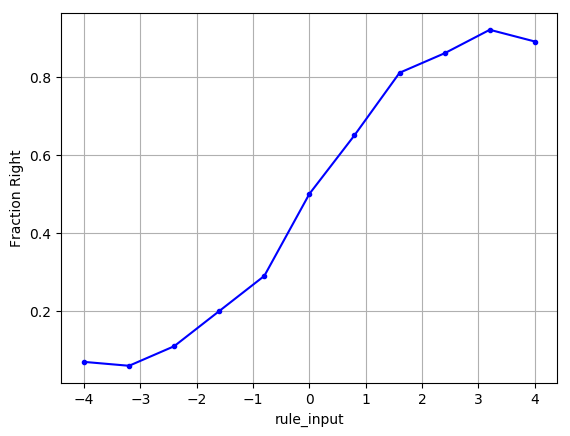

In [3]:
ntrials = 100
inputs = [-1:0.2:1;]*4
function psychometric(;ntrials=100, inputs=[-1:0.2:1;]*4, do_plot=false, pars...)
    fracright = zeros(size(inputs))
    wentright = zeros(1, ntrials)

    for input in [1:length(inputs);]
        for i in [1:ntrials;]
            outs = mgo_dynamics(;do_plot=do_plot, rule_input=inputs[input], pars...)[3][:,end]  # get the V matrix final point
            if outs[1] > outs[2]
                wentright[i] = 1
            else
                wentright[i] = 0
            end
            fracright[input] = mean(wentright)
            # @printf "     i: %d\n" i
        end
        @printf "Done %d\n" input
    end

    figure(2); clf();
    plot(inputs, fracright, "b.-")
    ylabel("Fraction Right")
    xlabel("rule_input")
    grid(true)
    println(figure(2))

    return  inputs, fracright
end;

psychometric(ntrials=ntrials, inputs=inputs, dt=5, sigma=0.4);

figure(1); clf();
for i in [1:10;]
    mgo_dynamics(do_plot=true, dt=5, sigma=0.4, rule_input=1.5)
end

figure(2)

# Differentiation example

In [ ]:
out = DiffBase.HessianResult([0.1, 0.1, 0.1])
keyword_hessian!(out, (;pars...) -> mgo_dynamics(;pars...)[3][1,end], ["const_E", "w_self", "w_other"], [15, 0, -20])

@printf "V[1] at end is %g\ngrad is " DiffBase.value(out)
print_vector(DiffBase.gradient(out))
@printf "\n\nHessian is\n"
DiffBase.hessian(out)

# Cost function

In [71]:
function make_dict(args, x::Vector)
    kwargs = Dict();
    for i in [1:length(args);]
        kwargs = merge(kwargs, Dict(Symbol(args[i]) => x[i]))
    end
    return kwargs
end 

function Jcost(;target=0.8, ntrials=10, theta1=0.15, theta2=0.2, beta=0.05, seedrand = 300, verbose=true,
    rulestrength = 2, nderivs=0, difforder=0, do_plot=false, plot_trials=1, max_sigma=1, min_sigma=0.05, 
    params...)

    function sigma_cost(;max_sigma=1, min_sigma=0.05, sigma=0.5, params...)
        if sigma<max_sigma && min_sigma<sigma;
            return 0
        elseif max_sigma <= sigma
            return cosh((sigma-max_sigma)/0.1)-1.0
        elseif sigma <= min_sigma
            return cosh((min_sigma-sigma)/0.1)-1.0
        end
    end

    if !isnan(seedrand)
        srand(seedrand)
    else  # if the random seed is passed as NaN, use the system time in milliseconds
        srand(convert(Int64, round(1000*time())))
    end
    
    if isempty(size(plot_trials))
        plot_trials = [plot_trials]
    end;

    Vouts1 = ForwardDiffZeros(2, ntrials, nderivs=nderivs, difforder=difforder)
    Vouts2 = ForwardDiffZeros(2, ntrials, nderivs=nderivs, difforder=difforder)

    if do_plot; figure(1); clf(); subplot(2,1,1); end
    for i in [1:ntrials;]
        if do_plot && ~isempty(find(plot_trials.==i))
            Vouts1[:,i] = mgo_dynamics(;do_plot=true, plot_only_V=true, rule_input=rulestrength,  nderivs=nderivs, difforder=difforder, params...)[3][:,end]
        else
            Vouts1[:,i] = mgo_dynamics(;rule_input=rulestrength,  nderivs=nderivs, difforder=difforder, params...)[3][:,end]
        end
    end
    if do_plot; subplot(2,1,2); end
    for i in [1:ntrials;]
        if do_plot && ~isempty(find(plot_trials.==i))
            Vouts2[:,i] = mgo_dynamics(;do_plot=true, plot_only_V=true, rule_input=-rulestrength, nderivs=nderivs, difforder=difforder, params...)[3][:,end]
        else
            Vouts2[:,i] = mgo_dynamics(;rule_input=-rulestrength, nderivs=nderivs, difforder=difforder, params...)[3][:,end]
        end
    end
    
    hits1 = 0.5*(1 + tanh.((Vouts1[1,:]  - Vouts1[2,:])/theta1))
    hits2 = 0.5*(1 + tanh.((Vouts2[2,:]  - Vouts2[1,:])/theta1))
    hits  = [hits1 ; hits2]
    diffs1   = tanh((Vouts1[1,:]  - Vouts1[2,:]) /theta2).^2
    diffs2   = tanh((Vouts2[1,:]  - Vouts2[2,:]) /theta2).^2
    diffs = [diffs1 ; diffs2]
        
    cost1 = (mean(hits) - target)^2 
    cost2 = -mean(diffs) 
    
    if verbose
        @printf("                              cost1=%g, cost2=%g, mean(hits)=%.3f, mean(diffs)=%.3f\n", 
            convert(Float64, cost1), beta*convert(Float64, cost2), 
            convert(Float64, mean(hits)), convert(Float64, mean(diffs)))
    end
    
    if do_plot
        figure(2); clf();
        subplot(2,1,1)
        plot(1:2*ntrials, hits, "."); vlines(ntrials+0.5, ylim()[1], ylim()[2]) 
        xlim(-1, ntrials*2+1)
        title("hits")

        subplot(2,1,2)
        plot(1:2*ntrials, diffs, "."); vlines(ntrials+0.5, ylim()[1], ylim()[2]) 
        xlim(-1, ntrials*2+1)
        title("diffs")
    end
    
    return cost1 + beta*cost2 + sigma_cost(;max_sigma=max_sigma, min_sigma=min_sigma, params...), hits, diffs
end

cost, hits, diffs = Jcost(do_plot=true, plot_trials=[1:10;], sigma=0.4)
hits'

                              cost1=0.00249449, cost2=-0.049923, mean(hits)=0.750, mean(diffs)=0.998


1×20 Array{Float64,2}:
 0.999997  0.999998  0.999995  3.24522e-6  …  0.999997  0.999989  0.999995

## Cost function involving multiple delay periods, zero response extra_E, and two rule strength levels.

Will this prove more informative and easier to minimize?

In [66]:
function Jcost2(;target=[0.8, 0.6], ntrials=10, theta1=0.15, theta2=0.2, beta=0.05, seedrand = 300, verbose=true,
    rulestrength = 2, nderivs=0, difforder=0, do_plot=false, plot_trials=1, 
    min_sigma=0, max_sigma=0, params...)

    if !isnan(seedrand)
        srand(seedrand)
    else  # if the random seed is passed as NaN, use the system time in milliseconds
        srand(convert(Int64, round(1000*time())))
    end
    
    if isempty(size(plot_trials))
        plot_trials = [plot_trials]
    end;

    Vouts1s = ForwardDiffZeros(2, ntrials, nderivs=nderivs, difforder=difforder)
    Vouts1w = ForwardDiffZeros(2, ntrials, nderivs=nderivs, difforder=difforder)
    Vouts2s = ForwardDiffZeros(2, ntrials, nderivs=nderivs, difforder=difforder)
    Vouts2w = ForwardDiffZeros(2, ntrials, nderivs=nderivs, difforder=difforder)

    if do_plot; figure(1); clf(); subplot(4,1,1); end
    for i in [1:ntrials;]
        if do_plot && ~isempty(find(plot_trials.==i))
            Vouts1s[:,i] = mgo_dynamics(;do_plot=true, plot_only_V=true, rule_input=rulestrength,  nderivs=nderivs, difforder=difforder, params...)[3][:,end]
        else
            Vouts1s[:,i] = mgo_dynamics(;rule_input=rulestrength,  nderivs=nderivs, difforder=difforder, params...)[3][:,end]
        end
    end
    if do_plot; subplot(4,1,2); end
    for i in [1:ntrials;]
        if do_plot && ~isempty(find(plot_trials.==i))
            Vouts1w[:,i] = mgo_dynamics(;do_plot=true, plot_only_V=true, rule_input=rulestrength/2, nderivs=nderivs, difforder=difforder, params...)[3][:,end]
        else
            Vouts1w[:,i] = mgo_dynamics(;rule_input=rulestrength/2, nderivs=nderivs, difforder=difforder, params...)[3][:,end]
        end
    end
    if do_plot; subplot(4,1,3); end
    for i in [1:ntrials;]
        if do_plot && ~isempty(find(plot_trials.==i))
            Vouts2w[:,i] = mgo_dynamics(;do_plot=true, plot_only_V=true, rule_input=-rulestrength/2, nderivs=nderivs, difforder=difforder, params...)[3][:,end]
        else
            Vouts2w[:,i] = mgo_dynamics(;rule_input=-rulestrength/2, nderivs=nderivs, difforder=difforder, params...)[3][:,end]
        end
    end
    if do_plot; subplot(4,1,4); end
    for i in [1:ntrials;]
        if do_plot && ~isempty(find(plot_trials.==i))
            Vouts2s[:,i] = mgo_dynamics(;do_plot=true, plot_only_V=true, rule_input=-rulestrength, nderivs=nderivs, difforder=difforder, params...)[3][:,end]
        else
            Vouts2s[:,i] = mgo_dynamics(;rule_input=-rulestrength, nderivs=nderivs, difforder=difforder, params...)[3][:,end]
        end
    end
    
    hits1s = 0.5*(1 + tanh.((Vouts1s[1,:]  - Vouts1s[2,:])/theta1))
    hits1w = 0.5*(1 + tanh.((Vouts1w[1,:]  - Vouts1w[2,:])/theta1))
    hits2s = 0.5*(1 + tanh.((Vouts2s[2,:]  - Vouts2s[1,:])/theta1))
    hits2w = 0.5*(1 + tanh.((Vouts2w[2,:]  - Vouts2w[1,:])/theta1))
    hits  = [hits1s ; hits1w ; hits2w ; hits2s]
    diffs1s   = tanh((Vouts1s[1,:]  - Vouts1s[2,:]) /theta2).^2
    diffs1w   = tanh((Vouts1w[1,:]  - Vouts1w[2,:]) /theta2).^2
    diffs2s   = tanh((Vouts2s[1,:]  - Vouts2s[2,:]) /theta2).^2
    diffs2w   = tanh((Vouts2w[1,:]  - Vouts2w[2,:]) /theta2).^2
    diffs = [diffs1s ; diffs1w ; diffs2w ; diffs2s]
        
    cost1  = (mean([hits1s ; hits2s]) - target[1])^2 
    cost1 += (mean([hits1w ; hits2w]) - target[2])^2 
    cost1 /= 2
    cost2  = -mean(diffs) 
    
    if verbose
        @printf("                              cost1=%g, cost2=%g, mean(hits)=%.3f, mean(diffs)=%.3f\n", 
            convert(Float64, cost1), beta*convert(Float64, cost2), 
            convert(Float64, mean(hits)), convert(Float64, mean(diffs)))
    end
    
    if do_plot
        figure(2); clf();
        subplot(2,1,1)
        plot(1:4*ntrials, hits, "."); vlines(ntrials*[1:3]+0.5, ylim()[1], ylim()[2]) 
        xlim(-1, ntrials*4+1)
        title("hits")

        subplot(2,1,2)
        plot(1:4*ntrials, diffs, "."); vlines(ntrials*[1:3]+0.5, ylim()[1], ylim()[2]) 
        xlim(-1, ntrials*4+1)
        title("diffs")
    end
    
    return cost1 + beta*cost2, hits, diffs
end

cost, hits, diffs = Jcost2(do_plot=true, plot_trials=[1:10;], ntrials=80)
hits'

                              cost1=0.0210998

, cost2=-0.0497652, mean(hits)=0.827, mean(diffs)=0.995


1×320 Array{Float64,2}:
 0.999997  0.999998  0.999995  3.24522e-6  …  0.999929  2.67237e-6  0.999983

In [64]:
cost

-0.02866539099547513

# Minimal system optimization

### Plotting the system itself

In [5]:
figure(1); clf();
for i=[1:40;]
    mgo_dynamics(do_plot=true, dt=25, cue_period=200, delay_period=200, response_period=300, sigma=0.4, const_E=15, 
        w_self=0, w_other=-20, rule_input=2)
end

figure(2); clf();
psychometric(dt=25, cue_period=200, delay_period=200, response_period=300, sigma=0.4, 
const_E=15, w_self=0, w_other=-20, inputs=[-5:1:5;], ntrials=40)

Done 1
Done 2
Done 3
Done 4
Done 5
Done 6
Done 7
Done 8
Done 9
Done 10
Done 11
PyPlot.Figure(PyObject <matplotlib.figure.Figure object at 0x322f8ded0>)


([-5,-4,-3,-2,-1,0,1,2,3,4,5],[0.025,0.025,0.125,0.175,0.275,0.475,0.675,0.875,0.9,1.0,1.0])

In [6]:
Jcost(beta=0.05, rulestrength=2, ntrials=40,do_plot=true, plot_trials=[5,6,7,8,9], dt=25, sigma=0.7,
    cue_period=200, delay_period=200, response_period=300, const_E=15, w_self=0, w_other=-20)

                              cost1=0.0440213, cost2=-0.0466114, mean(hits)=0.590, mean(diffs)=0.932


(-0.002590163318211415,[0.999998,0.999998,0.00229818,0.0639038,5.96483e-6,0.316463,0.999997,0.999997,0.999997,0.999997  …  0.99556,0.999974,0.999998,0.999996,0.999981,0.999997,0.983838,0.999996,1.83421e-6,2.22352e-6],[0.999809,0.999811,0.958813,0.584251,0.999517,0.0789662,0.999707,0.999741,0.999677,0.999679  …  0.933291,0.998526,0.999761,0.999614,0.998833,0.999717,0.83221,0.999631,0.999801,0.99977])

### Now the minimization.

#### After some effort, looking pretty good! In the space of [const_E, w_self, w_other, sigma], can start from pretty arbitrary points and get good target % correct and nice-looking separation in output activity.

Some of the lessons learnt:

1. The cost function is doing ok. Narrow range for theta1 (hit/miss border) and a low beta=0.01, so that the diff measure only begins to matter once the cost function is doing good.
2. We need a boundary on sigma!  Too big and the simulations become unstable. Too small and see problem #3 immediately below. For MGO, "soft wall" boundaries of 0.05 and 0.6 were good.
3. We're really trying to operate on probability distributions-- if we could do Fokker-Planck, we would. So it is important that sigma not be too small (if sigma is too small, it corresponds in the Fokker-Planck world to small ball distributions, which might have no mass crossing the decision threshold and therefore no derivative with respect to log-likelihood for binary choice data).  
4. Similarly, we want the number of trials being run to be large-ish (n=1000 seems ok for MGO), so that we're covering the range of possible outputs and the probability distribution is reasonably represented. In particular, we want at least a few trials that end up near the decision border, even when we're near the final desired parameter values, since these are the trials that give us a not-too-small derivative magnitude. With n=1000, there seem to be enough trials near the decision border that things work ok. With smaller n, we could get idiosyncratically stuck (n=40 worked ok, n=60 got stuck, n=200 ok, n=300 stuck, n=1000 good).
5. In sum, put your resources into large # of trials and decent noise for reasonable representation of the probability distribution. Don't spend your resources on many unnecessary timesteps.

And a general one for the simulations:

6. Adding sigma to U leads to better scaling w.r.t. dt than adding it to dUdt (because dUdt gets multiplied again by dt).  If we add it to U, then scaling by sqrt(dt) means very similar results for a wide range of dts.


In [ ]:
# args = ["const_E", "w_self", "w_other"]
# great = [15.0, 0, -20]
# seed = [-1.01, 0, 10]  # pretty cool bad seed!
args = ["const_E", "w_self", "w_other", "sigma"]
seed = [1.0, 0, 10, 0.3]   # pretty cool that starting from this wonky point it still makes it to the desired final output!
# args = ["const_E", "w_self", "w_other"]
seed = [26.3814, -40.0, -40.0, 0.6]
# seed = [20.3797,-30.0, -30.0,0.6]
# seed = [-1.01, 0, 10]  # pretty cool bad seed!  Far out but does fine.
params, trajectory1000 = constrained_Hessian_keyword_minimization(seed, args, maxiter=250, alpha=0.95, sdev_thresh=3,
(;pars...) -> Jcost(;beta=0.01, max_sigma=0.6, rulestrength=2, ntrials=4000, seedrand=185,
do_plot=false, plot_trials=[5,6,7,8,9], dt=25, verbose=true,
    cue_period=200, delay_period=200, response_period=300,  
    pars...)[1], verbose=true, tol=1e-7, start_eta=0.1);
params

In [ ]:
# Example of plotting a particular point in parameter space

Jcost(;beta=0.01, max_sigma=0.6, rulestrength=2, ntrials=600, seedrand=300,
do_plot=true, plot_trials=[5,6,7,8,9], dt=25, verbose=true,
    cue_period=200, delay_period=200, response_period=300,  
    make_dict(args, params)...)


In [ ]:
figure(3); clf();
plot(trajectory1000[2,1:136]); grid(true)

### Plotting and exploring some of the results

In [ ]:
###### trajectoryg = trajectoryg[:,1:132]
figure(3); clf();
for i in [1:6;]
    subplot(6,1,i)
    plot(trajectoryg[i,:], "b.-", trajectory[i,:], "r.-")
    grid(true)
    if i<6; setp(gca(), "xticklabels", []); end
    if i==1; ylabel("eta"); end
    if i==2; ylabel("cost"); end
    if i>2; ylabel(args[i-2]); end
end

ntrials=60; sigmas = 0.05:0.01:0.6; cs = zeros(length(sigmas),1)
for i in [1:length(sigmas);]
    cs[i] = Jcost(;beta=0.01, max_sigma=0.6, rulestrength=2, ntrials=1000, verbose=false,
        do_plot=false, plot_trials=[5,6,7,8,9], dt=25, 
        cue_period=200, delay_period=200, response_period=300, 
        make_dict(args, [trajectoryg[3:5, 30]; sigmas[i]])...)[1]
end
figure(4); clf(); 
plot(sigmas, cs, ".-"); grid(true)
println("done")

# for i in [1:ntrials;]
#    cs[i] = Jcost(;beta=0.05, rulestrength=2, ntrials=i,do_plot=true, plot_trials=[1:20;], dt=25,
#        cue_period=200, delay_period=200, response_period=300, make_dict(args, seed)...)[1]
# end
# plot([1:ntrials;], cs[:], ".-")

### Exploring how the random seeds affects success versus failure

Things are not quite working.  Changing the random seed from iteration to iteration appears to make it go nowhere, even when the number of trials is very high (a condition under which we would have expected the gradient and the Hessian to be very similar).

Debuggings to try:

1. Compare gradient and Hessian across different seeds
2. Try quadratic programming within variable ranges -- what if we occasionally test a jump to what the quadratic programming says is the global min? (Might not be the gradient=0 point, that might be a max or a saddle.)
3. Compare to Chuck's code, which was Fokker-Planck.  Ultimately, at high ntrials, we should approximate that?


In [ ]:
args = ["const_E", "w_self", "w_other", "sigma"]
seed = [1.0, 0, 10, 0.3]   # wonky seed; testing for how often we succeed despite the wonky seed.

trial_sets =  [600] # [300, 600, 1000] # [40, 60, 80, 100, 150] # , 40, 80, 160, 320, 640, 1280]
nseeds  = 50;
fullresults = zeros(length(trial_sets), 1+length(args), nseeds)
fracresults = ones(length(trial_sets), 1)*NaN
figure(4); clf();

for t in [1:length(trial_sets);]
    ntrials = trial_sets[t];
    @printf "About to try %d trials\n" ntrials
    
    for i in [1:nseeds;]
        @printf "     %d: trying seed %d\n" i i
        params, trajectory = constrained_Hessian_keyword_minimization(seed, args,
            (;pars...) -> Jcost(;beta=0.01, max_sigma=0.6, rulestrength=2, ntrials=ntrials, seedrand=i+2000,
        do_plot=false, plot_trials=[5,6,7,8,9], verbose=false, dt=25, 
                cue_period=200, delay_period=200, response_period=300,  
                pars...)[1], verbose=false, tol=1e-7, start_eta=1);

        fullresults[t,1,i] = trajectory[2,end]    # cost
        if trajectory[2,end] <= 0.005
            @printf "        ---success!\n"
        end
        fullresults[t,2:end,i] = params
    end
    fracresults[t] = length(find(fullresults[t,1,:].<=0.005))/nseeds
    
    figure(4)
    plot([1:length(fracresults);], fracresults, ".-")
    xlim(0, length(fracresults)+1)
end

#matwrite("fracresults6.mat", Dict("trial_sets" => trial_sets, "nseeds"=>nseeds, 
#    "fullresults"=>fullresults, "fracresults"=>fracresults))    

### Trying the above with bbox minimization

In [72]:
args = ["const_E", "w_self", "w_other", "sigma", "rulestrength"]
seed = [1.0, 0, -2, 0.3, 1]   # wonky seed; testing for how often we succeed despite the wonky seed.
# seed = [3.0, 10.1, -8.0, 0.15]
bbox = [0 20 ;
        0 16 ; 
        -16 0 ; 
        0.05 0.6 ; 
         0  3]

args = ["const_E", "w_self", "w_other", "sigma"]
seed = [1.0, 0, -2, 0.3]   # wonky seed; testing for how often we succeed despite the wonky seed.
# seed = [3.0, 10.1, -8.0, 0.15]
bbox = [0 20 ;
        0 16 ; 
        -16 0 ; 
        0.05 0.6]


trial_sets =  [40] # [300, 600, 1000] # [40, 60, 80, 100, 150] # , 40, 80, 160, 320, 640, 1280]
nseeds  = 100;
myseeds = 2000+[1:nseeds;]
myseeds = [2012 2026 2052 2058];   # These four seeds work. Adding one to each makes them not work.
myseeds = [2001:2020;]
nseeds  = length(myseeds)
# But successful seeds works no matter if the add one to the seed
fullresults = zeros(length(trial_sets), 1+length(args), nseeds)
fracresults = ones(length(trial_sets), 1)*NaN
seeds = Array{Float64}(length(trial_sets), nseeds)

figure(4); clf();

for t in [1:length(trial_sets);]
    ntrials = trial_sets[t];
    @printf "About to try %d trials\n" ntrials
    
    for i in [1:nseeds;]
        @printf "     %d: trying seed %d\n" i i
        func = (;pars...) -> Jcost(;beta=0.01, min_sigma=0.01, max_sigma=20, 
                rulestrength=2, ntrials=ntrials, seedrand=myseeds[i],
                do_plot=false, plot_trials=[5,6,7,8,9], verbose=false, dt=25, 
                cue_period=200, delay_period=200, response_period=300,  
                pars...)[1]
        params, trajectory = bbox_Hessian_keyword_minimization(seed, args, bbox, func, hardbox=false,
            verbose=false, tol=1e-7, start_eta=1, wallwidth_factor=0.18);

        fullresults[t,1,i] = trajectory[2,end]    # cost
        seeds[t,i] = myseeds[i]
        if trajectory[2,end] <= 0.005
            @printf "        ---success at first go!\n"
        else
            for k = [] # [1:5:size(trajectory,2);]
                sugg_value, sugg_x, wNL = kw_quadratic_guess(func, args, bbox, trajectory[3:end,k])
                @printf "             quadratic guess from k=%g says sugg_value=%g and wNL=%g\n" k sugg_value wNL                
                if !wNL && sugg_value <  trajectory[2,k]
                    @printf "             trying quadratic guess from k=%g\n" k
                    newpars, newtraj = bbox_Hessian_keyword_minimization(sugg_x, args, bbox, func,
                        verbose=false, tol=1e-10, start_eta=1, wallwidth_factor=0.18);
                    if newtraj[2,end] <= 0.005
                        @printf "             --success on quadratic guess from k=%g !\n" k
                        fullresults[t,1,i] = newtraj[2,end]
                        params = newpars
                        break
                    end
                end
            end
        end
        fullresults[t,2:end,i] = params
    end
    fracresults[t] = length(find(fullresults[t,1,:].<=0.005))/nseeds
    
    figure(4)
    plot([1:length(fracresults);], fracresults, ".-")
    xlim(0, length(fracresults)+1)
end

# matwrite("regular_fracresults7.mat", Dict("trial_sets" => trial_sets, "nseeds"=>nseeds, "seeds"=>seeds,
#    "fullresults"=>fullresults, "fracresults"=>fracresults))    
squeeze(fullresults,1)


About to try 40 trials
     1: trying seed 1
     2: trying seed 2
     3: trying seed 3
        ---success at first go!
     4: trying seed 4
     5: trying seed 5
     6: trying seed 6
     7: trying seed 7
     8: trying seed 8
     9: trying seed 9
        ---success at first go!
     10: trying seed 10
        ---success at first go!
     11: trying seed 11
     12: trying seed 12
        ---success at first go!
     13: trying seed 13
        ---success at first go!
     14: trying seed 14
        ---success at first go!
     15: trying seed 15
        ---success at first go!
     16: trying seed 16
     17: trying seed 17
        ---success at first go!
     18: trying seed 18
        ---success at first go!
     19: trying seed 19
        ---success at first go!
     20: trying seed 20


5×20 Array{Float64,2}:
  0.0542185     0.092352    -0.00982071  …   -0.00976869   0.0915416  
  5.86446      -0.002277     2.61252          6.81671     -0.00283383 
 -0.00338915   -2.35775e-5  16.0001           5.83953     -0.000545814
  0.00258063  -16.0         -6.61282        -10.1173       0.000741596
  0.600063      0.0496526    0.343017         0.240862     0.0498557  

#### Exactly as above but now just trying random start points instead of so-called "clever" quadratic guesses

In [76]:
args = ["const_E", "w_self", "w_other", "sigma", "rulestrength"]
seed = [1.0, 0, -2, 0.3, 1]   # wonky seed; testing for how often we succeed despite the wonky seed.
# seed = [3.0, 10.1, -8.0, 0.15]
bbox = [0 20 ;
        0 16 ; 
        -16 0 ; 
        0.05 0.6 ; 
         0  3]

args = ["const_E", "w_self", "w_other", "sigma"]
seed = [1.0, 0, 10, 0.3]   # wonky seed; testing for how often we succeed despite the wonky seed.
# seed = [3.0, 10.1, -8.0, 0.15]
bbox = [-20 20 ;
        -16 16 ; 
        -16 16 ; 
        0.05 0.6]


trial_sets =  [200] # [300, 600, 1000] # [40, 60, 80, 100, 150] # , 40, 80, 160, 320, 640, 1280]
nseeds  = 100;
myseeds = 2000+[1:nseeds;]
myseeds = [2012 2026 2052 2058];   # These four seeds work. Adding one to each makes them not work.
myseeds = [2001:2020;]
nseeds  = length(myseeds)
# But successful seeds works no matter if the add one to the seed
fullresults = zeros(length(trial_sets), 1+length(args), nseeds)
fracresults = ones(length(trial_sets), 1)*NaN
seeds = Array{Float64}(length(trial_sets), nseeds)

figure(4); clf();

for t in [1:length(trial_sets);]
    ntrials = trial_sets[t];
    @printf "About to try %d trials\n" ntrials
    
    for i in [1:nseeds;]
        @printf "     %d: trying seed %d\n" i i
        func = (;pars...) -> Jcost(;beta=0.01, min_sigma=0.01, max_sigma=20, 
                rulestrength=2, ntrials=ntrials, seedrand=myseeds[i],
                do_plot=false, plot_trials=[5,6,7,8,9], verbose=false, dt=25, 
                cue_period=200, delay_period=200, response_period=300,  
                pars...)[1]
        params, trajectory = bbox_Hessian_keyword_minimization(seed, args, bbox, func, hardbox=false,
            verbose=false, tol=1e-7, start_eta=1, wallwidth_factor=0.18);

        fullresults[t,1,i] = trajectory[2,end]    # cost
        seeds[t,i] = myseeds[i]
        if trajectory[2,end] <= 0.005
            @printf "        ---success at first go!\n"
        else
            for k = [1:2;] # [1:5:size(trajectory,2);]
                sugg_x = rand(length(args),1)[:].*(bbox[:,2]-bbox[:,1]) + bbox[:,1]
                @printf "             trying random guess rand iter k=%g\n" k
                newpars, newtraj = bbox_Hessian_keyword_minimization(sugg_x, args, bbox, func, hardbox=false,
                    verbose=false, tol=1e-10, start_eta=1, wallwidth_factor=0.1);
                if newtraj[2,end] <= 0.005
                    @printf "             --success on rand iter k=%g !\n" k
                    fullresults[t,1,i] = newtraj[2,end]
                    params = newpars
                    break
                end
            end
        end
        fullresults[t,2:end,i] = params
    end
    fracresults[t] = length(find(fullresults[t,1,:].<=0.005))/nseeds
    
    figure(4)
    plot([1:length(fracresults);], fracresults, ".-")
    xlim(0, length(fracresults)+1)
end

# matwrite("regular_fracresults7.mat", Dict("trial_sets" => trial_sets, "nseeds"=>nseeds, "seeds"=>seeds,
#    "fullresults"=>fullresults, "fracresults"=>fracresults))    
squeeze(fullresults,1)


About to try 200 trials
     1: trying seed 1
             trying random guess rand iter k=1
             --success on rand iter k=1 !
     2: trying seed 2
        ---success at first go!
     3: trying seed 3
             trying random guess rand iter k=1
             trying random guess rand iter k=2
     4: trying seed 4
             trying random guess rand iter k=1
             --success on rand iter k=1 !
     5: trying seed 5
             trying random guess rand iter k=1
             trying random guess rand iter k=2
     6: trying seed 6
        ---success at first go!
     7: trying seed 7
             trying random guess rand iter k=1
             trying random guess rand iter k=2
     8: trying seed 8
             trying random guess rand iter k=1
             --success on rand iter k=1 !
     9: trying seed 9
             trying random guess rand iter k=1
             --success on rand iter k=1 !
     10: trying seed 10
             trying random guess rand iter k=1
     

5×20 Array{Float64,2}:
  -0.00994145   -0.00980231   0.0859894  …    0.0709221    0.0874894
   4.91527       5.602       -0.289569        5.87545      0.0381632
   9.76172       8.55709      5.93992       -11.4716     -14.2559   
 -13.8219      -10.5747       9.57156        13.3612      15.0014   
   0.302684      0.275644     0.600073        0.600044     0.600011 

In [82]:
matwrite("fracresults8.mat", Dict("trial_sets" => trial_sets, "nseeds"=>nseeds, "seeds"=>seeds,
    "fullresults"=>fullresults, "fracresults"=>fracresults))    
figure(4); clf(); plot(fullresults[1,1,:], ".-")
fracresults

1×1 Array{Float64,2}:
 0.5

# Final setup-- try different random starts and noisy trials if necessary

In [112]:
args = ["const_E", "w_self", "w_other", "sigma", "rulestrength"]
bbox = [-20 20 ;
        -16 16 ; 
        -16 16 ; 
        0.05 0.6 ; 
        0.1  3]


ntrials =  200
max_attempts = 50
figure(4); clf();
nruns = 20
attempts_needed = zeros(1, nruns)
final_costs     = zeros(1, nruns)
randseeds       = zeros(Int64, 1, nruns)
final_params    = zeros(length(args), nruns)

for k in [1:nruns;]            
    local i
    local params
    local trajectory
    
    for i in [1:max_attempts;]                        
        randseeds[k] = convert(Int64, rem(round(time()*1e12), 1e6))
        
        
        func = (;pars...) -> Jcost(;beta=0.01, min_sigma=0.01, max_sigma=20, 
        rulestrength=2, ntrials=ntrials, seedrand=randseeds[k],    
            do_plot=false, plot_trials=[5,6,7,8,9], verbose=false, dt=25, 
            cue_period=200, delay_period=200, response_period=300,  
            pars...)[1]

        seed = rand(length(args),1)[:].*(bbox[:,2]-bbox[:,1]) + bbox[:,1]

        params, trajectory = bbox_Hessian_keyword_minimization(seed, args, bbox, func, hardbox=false,
            verbose=false, tol=1e-12, start_eta=1, wallwidth_factor=0.18);

        @printf "Attempt %d with seed %d ended with cost %g\n" i randseeds[k] trajectory[2,end]

        if trajectory[2,end] <= -0.005
            @printf "        ---success!\n"        
            break    
        end
    end

    
    final_params[:,k] = params
    final_costs[k] = trajectory[2,end]
    attempts_needed[k] = i
    @printf "\n---------- Finished run %d --------\n" k
end

matwrite("attempt_distribution.mat", Dict("attempts_needed" => attempts_needed, "ntrials"=>ntrials, 
"max_attempts" => max_attempts, "randseeds"=>randseeds, "final_costs"=>final_costs, "final_params"=>final_params))

figure(4); clf();
ax = gca();
ax[:hist](attempts_needed');
xlabel("no. of atempts needed")
ylabel("no. of runs")

Attempt 1 width seed 905792 ended with cost 0.0900014
Attempt 2 width seed 189504 ended with cost -0.00969496
        ---success!

---------- Finished run 1 --------
Attempt 1 width seed 85248 ended with cost 0.0751175
Attempt 2 width seed 976832 ended with cost 0.0900006
Attempt 3 width seed 989952 ended with cost 0.0758933
Attempt 4 width seed 43712 ended with cost 0.0834154
Attempt 5 width seed 880320 ended with cost -0.00955812
        ---success!

---------- Finished run 2 --------
Attempt 1 width seed 787584 ended with cost -0.00981188
        ---success!

---------- Finished run 3 --------
Attempt 1 width seed 963776 ended with cost 0.0902202
Attempt 2 width seed 157888 ended with cost -0.00993911
        ---success!

---------- Finished run 4 --------
Attempt 1 width seed 815872 ended with cost 0.067885
Attempt 2 width seed 979328 ended with cost -0.00949908
        ---success!

---------- Finished run 5 --------
Attempt 1 width seed 105344 ended with cost 0.0900013
Attempt 2 w

PyObject <matplotlib.text.Text object at 0x335469ed0>

In [133]:
matwrite("attempt_distribution.mat", Dict("attempts_needed" => attempts_needed, "ntrials"=>ntrials, 
"max_attempts" => max_attempts, "randseeds"=>randseeds, "final_costs"=>final_costs, "final_params"=>final_params,
"args"=>args, "bbox"=>bbox, "ntrials"=>ntrials))


In [132]:
figure(4);
clf()
println(args)
plot(final_params[1,:], final_params[5,:], "o")

value, grad, hess = keyword_vgh(func, args, final_params[:,1])

eig((hess))[2]

String["const_E","w_self","w_other","sigma","rulestrength"]


5×5 Array{Float64,2}:
 -0.172527    -0.847478    0.053415   -0.498428    0.0270427
 -0.0964268   -0.358468    0.39767     0.657193   -0.521688 
  0.00942839   0.0271923   0.761265    0.0670423   0.644323 
  0.972623    -0.22604    -0.0222458   0.046198    0.0167835
 -0.121871    -0.318509   -0.508906    0.559498    0.55828  

### ---  end final setup ----

In [ ]:
myseed = 2013  # 2012 is a nice seed
func = (;pars...) -> Jcost(;beta=0.01, max_sigma=0.6, rulestrength=2, ntrials=ntrials, seedrand=myseed,
                do_plot=false, plot_trials=[5,6,7,8,9], verbose=false, dt=25, 
                cue_period=200, delay_period=200, response_period=300,  
                pars...)[1]
params, trajectory = bbox_Hessian_keyword_minimization(seed, args, bbox, func,
        verbose=false, tol=1e-7, start_eta=1, wallwidth_factor=0.1);

figure(2); clf(); plot(trajectory[2,:])
println("Final cost is ", trajectory[2,end])
params

In [ ]:
i=6
pars = trajectory[3:end,i]
value, grad, hess = keyword_vgh(func, args, pars)
@printf "Eigenvalues of the Hessian: "
evalues = eig(hess)[1]
print_vector(evalues)
@printf "\n"
if any(evalues.<0)
    @printf "---- Have negative eigenvalues, testing for quadratic jump ---\n"
    min_limits = bbox[:,1]
    max_limits = bbox[:,2]

    m = Model(solver=IpoptSolver(print_level=0))
    @variable(m, min_limits[i]-pars[i] <= x[i=1:length(grad)] <= max_limits[i]-pars[i])
    @objective(m, Min, (0.5*x'*hess*x + x'*grad)[1] )

    status = solve(m, suppress_warnings=true)
    println("Quadratic objective value: ", getobjectivevalue(m))
    println("oldpt = ", pars)
    println("newpt = ", getvalue(x)+pars)
    newpt = getvalue(x)+pars

    println("pars  quad objective value = ", 0)
    println("newpt quad objective value = ", 0.5*(newpt-pars)'*hess*(newpt-pars) + (newpt-pars)'*grad)

    println("pars  full objective value = ", value)
    newvalue = func(;make_dict(args, newpt)...)
    println(typeof(newvalue))
    println("newpt full objective value = ", newvalue)
end

In [ ]:
tparams, ttrajectory = bbox_Hessian_keyword_minimization(newpt, args, bbox, func,
    verbose=false, tol=1e-10, start_eta=1, wallwidth_factor=0.1)
println("Final cost is ", ttrajectory[2,end])
tparams


#### Testing syntax of adding another search parameter, but this time at the level of Jcost

In [14]:
args = ["const_E", "w_self", "w_other", "sigma", "rulestrength"]
seed = [1.0, 0, 10, 0.3, 2]   # wonky seed; testing for how often we succeed despite the wonky seed.
# seed = [3.0, 10.1, -8.0, 0.15]
bbox = [-20 20 ;
        -16 16 ; 
        -16 16 ; 
        0.05 0.6 ; 
        0.2 3]


# args = ["const_E", "w_self", "w_other", "sigma"]
# seed = [1.0, 0, 10, 0.3]   # wonky seed; testing for how often we succeed despite the wonky seed.
# seed = [3.0, 10.1, -8.0, 0.15]
# bbox = [-20 20 ;  -16 16 ;    -16 16 ;        0.05 0.6]

          
func = (;pars...) -> Jcost(;beta=0.01, max_sigma=0.7, ntrials=40, seedrand=2011,
do_plot=false, plot_trials=[5,6,7,8,9], verbose=false, dt=25, 
    cue_period=200, delay_period=200, response_period=300,  
    pars...)[1]

tparams, ttrajectory = bbox_Hessian_keyword_minimization(seed, args, bbox, func,
    verbose=true, tol=1e-7, start_eta=1, wallwidth_factor=0.1)
println("Final cost is ", ttrajectory[2,end])
tparams


0: eta=1 ps=[1.000, 0.000, 10.000, 0.300, 2.000]
1: eta=0.5 cost=0.1027 jtype=constrained costheta=NaN ps=[1.000, 0.000, 10.000, 0.300, 2.000]
Constrained parabolic minimization failed with error ArgumentError("collection must be non-empty")

eta was 0.5
grad was
[0.010, 0.007, 0.005, -7363920.347, -0.000]

hess was
[-0.002, -0.000, -0.000, 0.005, -0.000]
[-0.000, -0.000, 0.000, -0.001, -0.000]
[-0.000, 0.000, -0.000, 0.001, -0.000]
[0.005, -0.001, 0.001, 133816815.562, 0.000]
[-0.000, -0.000, -0.000, 0.000, 0.000]

2: eta=0.25 cost=0.1027 jtype=failed costheta=NaN ps=[1.000, 0.000, 10.000, 0.300, 2.000]
Constrained parabolic minimization failed with error ArgumentError("collection must be non-empty")

eta was 0.25
grad was
[0.010, 0.007, 0.005, -7363920.347, -0.000]

hess was
[-0.002, -0.000, -0.000, 0.005, -0.000]
[-0.000, -0.000, 0.000, -0.001, -0.000]
[-0.000, 0.000, -0.000, 0.001, -0.000]
[0.005, -0.001, 0.001, 133816815.562, 0.000]
[-0.000, -0.000, -0.000, 0.000, 0.000]

3: eta=0

5-element Array{Float64,1}:
 -6.54915 
 10.1758  
 16.0008  
  0.600037
  2.99902 

In [ ]:
value, grad, hess = keyword_vgh(func, args, trajectory[3:end,1])


In [ ]:
fname = "regular_fracresults7.mat"; [matread(fname)["fracresults"] matread(fname)["trial_sets"]]
fullresults = matread(fname)["fullresults"]; seeds = matread(fname)["seeds"]
figure(4); clf();
plot(fullresults[1,1,:])
seeds[find(fullresults[1,1,:].<=0)]


In [ ]:
args = ["const_E", "w_self", "w_other", "sigma"]
seed = [1.0, 0, 10, 0.3]   # wonky seed; testing for how often we succeed despite the wonky seed.
# seed = params

ntrials=1000

out1 = DiffBase.HessianResult(seed)
out2 = DiffBase.HessianResult(seed)
keyword_hessian!(out1, (;pars...) -> Jcost(;beta=0.01, max_sigma=0.6, rulestrength=2, ntrials=ntrials, seedrand=140,
        do_plot=false, plot_trials=[5,6,7,8,9], verbose=false, dt=25, 
                cue_period=200, delay_period=200, response_period=300,  
                pars...)[1], args, seed)
keyword_hessian!(out2, (;pars...) -> Jcost(;beta=0.01, max_sigma=0.6, rulestrength=2, ntrials=ntrials, seedrand=150,
        do_plot=false, plot_trials=[5,6,7,8,9], verbose=false, dt=25, 
                cue_period=200, delay_period=200, response_period=300,  
                pars...)[1], args, seed)

o1 = DiffBase.value(out1)
o2 = DiffBase.value(out2)
g1 = DiffBase.gradient(out1)
g2 = DiffBase.gradient(out2)
h1 = DiffBase.hessian(out1)
h2 = DiffBase.hessian(out2)



In [ ]:
eig(h1)

# Quadratic programming

In [ ]:
using JuMP
using Ipopt

H = hess
G = grad

min_limits = [0.0,-30.0, -30.0, 0.0001]
max_limits = [40.0, 30.0, 0.0, 0.6]

m = Model(solver=IpoptSolver(print_level=0))
@variable(m, min_limits[i]-seed[i] <= x[i=1:length(G)] <= max_limits[i]-seed[i])
@objective(m, Min, (0.5*x'*H*x + x'*G)[1] )


# print(m)

status = solve(m, suppress_warnings=true)
println("Objective value: ", getobjectivevalue(m))
println("newpt = ", getvalue(x)+seed)
newpt = getvalue(x)+seed

println("seed  objective value = ", 0.5*(seed-seed)'*H*(seed-seed) + (seed-seed)'*G)
println("newpt objective value = ", 0.5*(newpt-seed)'*H*(newpt-seed) + (newpt-seed)'*G)


In [ ]:
filename = "fracresults5.mat"
fres = [fres; [matread(filename)["trial_sets"] matread(filename)["fracresults"]]]

In [ ]:
fres2 = fres[[1,2,6,4,7,11,9,10,12,13,14],:]
fres2[end,2] = 0.105
fres2
convert(Int64, round(time()))

In [ ]:
trajectory[:,end]

# Optimization

In [ ]:
args = ["const_E", "w_self", "w_other", "sigma"]
great = [15.0, 0, -20, 0.4]
seed = [5.01, 0, -5, 0.4]
badseed = [5.01, 0, -1]
badseedcont = [2.76086, 1.6075, -9.80835]
params = constrained_Hessian_keyword_minimization(seed, args,
(;pars...) -> Jcost(;ntrials=40,do_plot=true, plot_trials=[5,6,7,8,9], dt=5, response_extra_E=0,
beta=0, pars...)[1], verbose=true, tol=1e-9, start_eta=0.01)

In [ ]:
breakpoint("In[8]", 43)

In [ ]:

args = ["const_E", "w_self", "w_other", "sigma"]
seed = [1.0, 0, 10, 0.3]   # pretty cool that starting from this wonky point it still makes it to the desired final output!
# seed = [18, -10, -18.0, 0.6]
# seed = [10, 0.1, -2, 0.1]
bbox = [-20 20 ;
        -20  20 ; 
        -20  20 ; 
        0.05 0.6]

func = (;pars...) -> Jcost(;beta=0.01, rulestrength=2, ntrials=1000, seedrand=185, min_sigma=0.05, max_sigma=0.6,
        do_plot=false, plot_trials=[5,6,7,8,9], dt=25, verbose=true,
        cue_period=200, delay_period=200, response_period=300,  
        pars...)[1]

params, trajectory1000 = constrained_Hessian_keyword_minimization(seed, args, func, 
    verbose=true, tol=1e-7, start_eta=0.1, maxiter=250);

params

In [ ]:
pars = [0, 1, -1, 0.300]

out = DiffBase.HessianResult(pars)
keyword_hessian!(out, (;pars...) -> Jcost(;beta=0.01, rulestrength=2, ntrials=1000, seedrand=185, min_sigma=0.001, max_sigma=2,
        do_plot=false, plot_trials=[5,6,7,8,9], dt=25, verbose=true,
        cue_period=200, delay_period=200, response_period=300,  
        pars...)[1], args, pars)


using JuMP
using Ipopt

H = DiffBase.hessian(out)
G = DiffBase.gradient(out)

min_limits = bbox[:,1]
max_limits = bbox[:,2]

m = Model(solver=IpoptSolver(print_level=0))
@variable(m, min_limits[i]-pars[i] <= x[i=1:length(G)] <= max_limits[i]-pars[i])
@objective(m, Min, (0.5*x'*H*x + x'*G)[1] )


# print(m)

status = solve(m, suppress_warnings=true)
println("Objective value: ", getobjectivevalue(m))
println("newpt = ", getvalue(x)+pars)
newpt = getvalue(x)+pars

println("seed  objective value = ", 0.5*(pars-pars)'*H*(pars-pars) + (pars-pars)'*G)
println("newpt objective value = ", 0.5*(newpt-pars)'*H*(newpt-pars) + (newpt-pars)'*G)



In [ ]:
bbox

### bbox_Hessian_keyword_minimization

In [44]:
"""
function bbox_Hessian_keyword_minimization(seed, args, bbox, func; wallwidth=NaN, start_eta=10, tol=1e-6, 
    maxiter=400, verbose=false)

Like constrained_Hessian_minimization, but uses keyword_hessian!(). 

PARAMETERS:
===========

seed        column vector, representing the starting value of the parameters.

args        List of strings identifying parameters for differentiation, e.g., ["const_E", "w_self]

func        func must take only optional keyword args, and must 
            take nderivs=0, difforder=0  and declare any new matrices using ForwardDiffZeros() instead of zeros()


OPTIONAL PARAMETERS:
====================

start_eta=10 Starting value of the radius.  It's good to start with somethibg biggish, if it is
             too much, it'll quickly get cut down.

tol=1e-6     Numerical tolerance. If a proposed jump produces a change in func that is less than
             this, the minimization stops.

maxiter=400  Maximum number of iterations to do before stopping

verbose=false   If true, print out a report on each iteration of iteration number, radius size (eta),
                what type jump was proposed ("Newton" means going straight to global min, "constrained" means jump has 
                norm eta, failed means that finding the minimum at a given radius somehow didn't work). Will also
                print out the cosine of the angle between the proposed jump and the gradient.

RETURNS:
========

params       A vector the size of seed that has the last values of the minimizing parameters for func

"""
function bbox_Hessian_keyword_minimization(seed, args, bbox, func; start_eta=10, tol=1e-6, maxiter=400,
    verbose=false, wallwidth=NaN, wallwidth_factor=0.1, hardbox=true)
    
    """
    Given args, a list of string representing the arguments of interest, a bounding box for each,
    and a Symbol=>value dictionary with the corresponding parameters, computes and returns a high cost for 
    being outside the bounding box
    """
    function wall_cost(args, bbox; wallwidth=NaN, nderivs=0, difforder=0, pars...) 
        myparams = ForwardDiffZeros(length(pars), 1, nderivs=nderivs, difforder=difforder)
        pars2 = Dict()
        for i in [1:length(pars);]
            pars2[string(pars[i][1])] = pars[i][2]
        end
        for i in [1:length(args);]
            myparams[i] = pars2[args[i]]
        end
        
        if isnan(wallwidth)
            # We know that we're going to be taking hessian for params, so declare zeros accordingly:
            wallwidth = ForwardDiffZeros(length(myparams), 1, nderivs=nderivs, difforder=difforder)

            for i in [1:length(myparams);]
                wallwidth[i] = wallwidth_factor*(bbox[i,2]-bbox[i,1])
            end
        end

        retval = 0
        for i in [1:length(myparams);]
            if myparams[i]<bbox[i,1]
                retval += cosh((bbox[i,1]-myparams[i])/wallwidth[i])-1.0
            elseif bbox[i,2] < myparams[i]
                retval += cosh((myparams[i]-bbox[i,2])/wallwidth[i])-1.0                
            end
        end

        return 2*retval
    end

    
    traj_increment = 100
    params = seed
    eta = start_eta
    trajectory = zeros(2+length(params), traj_increment)

    if verbose
        @printf "%d: eta=%g ps=" 0 eta 
        print_vector(params)
        @printf "\n"
    end
    
    if hardbox
        cost, grad, hess = keyword_vgh((;pars...) -> func(;pars...), args, params)
    else
        cost, grad, hess = keyword_vgh((;pars...) -> func(;pars...) + wall_cost(args, bbox; wallwidth=wallwidth, pars...),
            args, params)        
    end
        
    chessdelta = zeros(size(params))

    for i in [1:maxiter;]
        if i > size(trajectory, 2)
            trajectory = [trajectory zeros(2+length(params), traj_increment)]
        end
        trajectory[1:2, i]   = [eta;cost]
        trajectory[3:end, i] = params
        
        hessdelta  = - inv(hess)*grad
        try
            chessdelta = constrained_parabolic_minimization(hess, grad'', eta)[1]
            jumptype = "not failed"
        catch y
            jumptype = "failed"
            if verbose
                @printf "Constrained parabolic minimization failed with error %s\n" y
                @printf "\n"
                @printf "eta was %g\n" eta
                @printf "grad was\n"
                print_vector(grad)
                @printf "\n\nhess was\n"
                for k in [1:length(grad);]
                    print_vector(hess[k,:])
                    @printf "\n"
                end
                @printf "\n"
            end
        end

        if norm(hessdelta) <= eta
            new_params = params + hessdelta
            jumptype = "Newton"
        elseif jumptype != "failed" 
            new_params = params + chessdelta
            jumptype  = "constrained"
        end

        if jumptype != "failed"
            if hardbox
                for p in [1:length(new_params);]
                    if new_params[p] < bbox[p,1]; new_params[p] = bbox[p,1]; end
                    if bbox[p,2] < new_params[p]; new_params[p] = bbox[p,2]; end
                 end        
                
                new_cost, new_grad, new_hess = keyword_vgh((;pars...) -> func(;pars...), args, new_params)
            else
                new_cost, new_grad, new_hess = keyword_vgh((;pars...) -> func(;pars...) + wall_cost(args, bbox; wallwidth=wallwidth, pars...),
                    args, new_params)                
            end
            
            if abs(new_cost - cost) < tol || eta < tol
                trajectory = trajectory[:,1:i]
                break
            end
        end

        if jumptype == "failed" || new_cost >= cost  
            eta = eta/2
            costheta = NaN
            if eta < tol
                trajectory = trajectory[:,1:i]
                break
            end
        else
            eta = eta*1.1
            costheta = dot(new_params-params, grad)/(norm(new_params-params)*norm(grad))

            params = new_params
            cost = new_cost
            grad = new_grad
            hess = new_hess
        end

        if verbose
            @printf "%d: eta=%g cost=%.4f jtype=%s costheta=%.3f ps=" i eta cost jumptype costheta
            print_vector(params)
            @printf "\n"
        end
    end
    
    return params, trajectory
end


bbox_Hessian_keyword_minimization

In [35]:
args = ["const_E", "w_self", "w_other", "sigma", "rulestrength"]
seed = [1.0, 0, 10, 0.3, 1]   
bbox = [-20 20 ;
        -16 16 ; 
        -16 16 ; 
        0.05 0.6;
        0.1  3]

func = (;pars...) -> Jcost(;beta=0.01, max_sigma=0.6, ntrials=ntrials, seedrand=2012,
    do_plot=true, plot_trials=[5,6,7,8,9], verbose=true, dt=25, 
    cue_period=200, delay_period=200, response_period=300,  
    pars...)[1]
    
params, trajectory = bbox_Hessian_keyword_minimization(seed, args, bbox, func,
    verbose=true, tol=1e-7, start_eta=1, wallwidth_factor=0.1)


0: eta=1 ps=[1.000, 0.000, 10.000, 0.300, 1.000]
                              cost1=0.0997065, cost2=-0.00400794, mean(hits)=0.484, mean(diffs)=0.401
                              cost1=0.0952665, cost2=-0.00538187, mean(hits)=0.491, mean(diffs)=0.538
1: eta=1.1 cost=0.0899 jtype=constrained costheta=-0.758 ps=[1.073, 0.308, 10.399, 0.600, 1.000]
                              cost1=0.0912531, cost2=-0.00518586, mean(hits)=0.498, mean(diffs)=0.519
2: eta=1.21 cost=0.0861 jtype=constrained costheta=-0.253 ps=[0.950, 1.143, 11.104, 0.600, 1.004]
                              cost1=0.088217, cost2=-0.00496205, mean(hits)=0.503, mean(diffs)=0.496
3: eta=1.331 cost=0.0833 jtype=constrained costheta=-0.184 ps=[0.408, 2.060, 11.678, 0.600, 0.994]
                              cost1=0.0861385, cost2=-0.00479103, mean(hits)=0.507, mean(diffs)=0.479
4: eta=1.4641 cost=0.0813 jtype=constrained costheta=-0.405 ps=[-0.362, 3.034, 12.162, 0.600, 0.980]
                              cost1=0.0873916, 

([1.79861,16.0,-8.72503,0.152356,1.4818],
[1.0 1.1 … 0.0603999 0.0302; 0.0956985 0.0898846 … -0.00997933 -0.00997933; … ; 0.3 0.6 … 0.152356 0.152356; 1.0 1.00016 … 1.4818 1.4818])

#### kw_quadratic_guess(func, argx, bbox, x0)     

We usually want to define this

In [24]:
using JuMP
using Ipopt

"""
function newvalue, newx, was_Newton_like = kw_quadratic_guess(func, args, bbox, x0)

Takes a scalar function, called with keywords to specify parameter identities, and given a bounding box 
and a starting point, computes the point that would minimize the function within the bounding box, 
according to a quadratic approzimation; then computes the value of the full function at that suggested point. 
Returns value at new point, new point, and a Boolean that is true of all the eigenvalues of the hessian were 
positive.
    
"""
function kw_quadratic_guess(func, args, bbox, x0)
    value, grad, hess = keyword_vgh(func, args, x0)
    
    min_limits = bbox[:,1]
    max_limits = bbox[:,2]

    m = Model(solver=IpoptSolver(print_level=0))
    @variable(m, min_limits[i]-x0[i] <= x[i=1:length(grad)] <= max_limits[i]-x0[i])
    @objective(m, Min, (0.5*x'*hess*x + x'*grad)[1] )

    status = solve(m, suppress_warnings=true)
    newx = getvalue(x)+x0
    
    newvalue = func(;make_dict(args, newx)...)
    
    return newvalue, newx, all(eig(hess)[1].>0)
end

kw_quadratic_guess

In [ ]:
    function wall_cost(args, bbox; wallwidth=NaN, nderivs=0, difforder=0, pars...) 
        myparams = ForwardDiffZeros(length(pars), 1, nderivs=nderivs, difforder=difforder)
        pars2 = Dict()
        for i in [1:length(pars);]
            pars2[string(pars[i][1])] = pars[i][2]
        end
        for i in [1:length(args);]
            myparams[i] = pars2[args[i]]
        end

        if isnan(wallwidth)
            # We know that we're going to be taking hessian for params, so declare zeros accordingly:
            wallwidth = ForwardDiffZeros(length(myparams), 1, nderivs=nderivs, difforder=difforder)

            for i in [1:length(myparams);]
                wallwidth[i] = 0.01*(bbox[i,2]-bbox[i,1])
            end
        end

        retval = 0
        for i in [1:length(myparams);]
            if myparams[i]<bbox[i,1]
                retval += cosh((bbox[i,1]-myparams[i])/wallwidth[i])-1.0
            elseif bbox[i,2] < params[i]
                retval += cosh((myparams[i]-bbox[i,2])/wallwidth[i])-1.0                
            end
        end

        return retval
    end

function tester(;x=10, y=20, nderivs=0, difforder=0)
    return x^2 + 2.3*x*y + 30*y
end

args = ["x", "y"]
params = [13, 20.0]
bbox = [5.0 15 ;
        10 30]
wallwidth = NaN

D = make_dict(args, params)
tester(; D...)+wall_cost(args, bbox, wallwidth=wallwidth; D...)

out = DiffBase.HessianResult(params)
keyword_hessian!(out, (;pars...) -> tester(;pars...) + wall_cost(args, bbox; wallwidth=wallwidth, pars...), args, params)
cost = DiffBase.value(out)
grad = DiffBase.gradient(out)
hess = DiffBase.hessian(out)

println("----")
println(cost)
println(grad)
hess


In [ ]:
args = ["const_E", "w_self", "w_other", "sigma"]
seed = [20, -20.0, -20.0, 0.6]
bbox = [-20 20 ;
        -20  0 ; 
        -20  0 ; 
        0.05 0.6]
wallwidth=NaN

out = DiffBase.HessianResult(seed)

keyword_hessian!(out, (;pars...) -> Jcost(;beta=0.01, rulestrength=2, ntrials=40, seedrand=185, min_sigma=0.001, max_sigma=2,
        do_plot=false, plot_trials=[5,6,7,8,9], dt=25, verbose=true,
        cue_period=200, delay_period=200, response_period=300,  
        pars...)[1]  + wall_cost(args, bbox; wallwidth=wallwidth, pars...), args, seed);

cost = DiffBase.value(out)
grad = DiffBase.gradient(out)
hess = DiffBase.hessian(out)


In [ ]:
y = Dict()
y["a"] = 20


### constrained_Hessian_keyword_minimization

In [ ]:
"""
function constrained_Hessian_keyword_minimization(seed, args, func; start_eta=10, tol=1e-6, maxiter=400,
    verbose=false)

Like constrained_Hessian_minimization, but uses keyword_hessian!(). 

PARAMETERS:
===========

seed        column vector, representing the starting value of the parameters.

args        List of strings identifying parameters for differentiation, e.g., ["const_E", "w_self]

func        func must take only optional keyword args, and must 
            take nderivs=0, difforder=0  and declare any new matrices using ForwardDiffZeros() instead of zeros()


OPTIONAL PARAMETERS:
====================

start_eta=10 Starting value of the radius.  It's good to start with somethibg biggish, if it is
             too much, it'll quickly get cut down.

tol=1e-6     Numerical tolerance. If a proposed jump produces a change in func that is less than
             this, the minimization stops.

maxiter=400  Maximum number of iterations to do before stopping

verbose=false   If true, print out a report on each iteration of iteration number, radius size (eta),
                what type jump was proposed ("Newton" means going straight to global min, "constrained" means jump has 
                norm eta, failed means that finding the minimum at a given radius somehow didn't work). Will also
                print out the cosine of the angle between the proposed jump and the gradient.

RETURNS:
========

params       A vector the size of seed that has the last values of the minimizing parameters for func

"""
function constrained_Hessian_keyword_minimization(seed, args, func; start_eta=10, tol=1e-6, maxiter=400,
    verbose=false, alpha = 0.9, sdev_thresh=3)

    traj_increment = 100
    params = seed
    eta = start_eta
    trajectory = zeros(2+length(params), traj_increment)

    if verbose
        @printf "%d: eta=%g ps=" 0 eta 
        print_vector(params)
        @printf "\n"
    end

    expo_mean_cost = 0
    expo_ssqu_cost = 0
    expo_sdev_cost = 0
    
    out = DiffBase.HessianResult(params)
    keyword_hessian!(out, (;pars...) -> func(;pars...), args, params)
    cost = DiffBase.value(out)
    grad = DiffBase.gradient(out)
    hess = DiffBase.hessian(out)

    chessdelta = zeros(size(params))

    for i in [1:maxiter;]
        if i > size(trajectory, 2)
            trajectory = [trajectory zeros(2+length(params), traj_increment)]
        end
        trajectory[1:2, i]   = [eta;cost]
        trajectory[3:end, i] = params
        
        hessdelta  = - inv(hess)*grad
        try
            chessdelta = constrained_parabolic_minimization(hess, grad'', eta)[1]
            jumptype = "not failed"
        catch y
            jumptype = "failed"
            if verbose
                @printf "Constrained parabolic minimization failed with error %s\n" y
                @printf "\n"
                @printf "eta was %g\n" eta
                @printf "grad was\n"
                print_vector(grad)
                @printf "\n\nhess was\n"
                for k in [1:length(grad);]
                    print_vector(hess[k,:])
                    @printf "\n"
                end
                @printf "\n"
            end
        end

        if norm(hessdelta) <= eta
            new_params = params + hessdelta
            jumptype = "Newton"
        elseif jumptype != "failed" 
            new_params = params + chessdelta
            jumptype  = "constrained"
        end

        if jumptype != "failed"
            keyword_hessian!(out, (;pars...) -> func(;pars...), args, new_params)
            new_cost = DiffBase.value(out)
            new_grad = DiffBase.gradient(out)
            new_hess = DiffBase.hessian(out)
                        
            if abs(new_cost - cost) < tol || eta < tol
                trajectory = trajectory[:,1:i]
                break
            end
        end

        if jumptype == "failed" || new_cost >= cost  # (i > 10 && new_cost >= expo_mean_cost + sdev_thresh*expo_sdev_cost)
            eta = eta/2
            costheta = NaN
        else
            eta = eta*1.1
            costheta = dot(new_params-params, grad)/(norm(new_params-params)*norm(grad))

            params = new_params
            cost = new_cost
            grad = new_grad
            hess = new_hess

            expo_mean_cost = (alpha*(expo_mean_cost/(1-alpha))   + cost  )*(1-alpha)
            expo_ssqu_cost = (alpha*(expo_ssqu_cost/(1-alpha))   + cost^2)*(1-alpha)
            if expo_ssqu_cost - expo_mean_cost^2 > 0
                expo_sdev_cost =  sqrt(expo_ssqu_cost - expo_mean_cost^2)
            else
                expo_sdev_cost = Inf
            end

        end

        if verbose
            @printf "%d: eta=%g cost=%.4f em=%.4f esd=%.4f jtype=%s costheta=%.3f ps=" i eta cost expo_mean_cost expo_sdev_cost jumptype costheta
            print_vector(params)
            @printf "\n"
        end
    end
    
    return params, trajectory
end


In [ ]:
breakpoint("In[3]", 43)

In [ ]:
ntrials=800
alpha = 0.9
expo_mean = 0
expo_ssqu = 0

for i in [1:ntrials;]
    newval = randn()*0.2 + 1.5
    
    expo_mean = (alpha*(expo_mean/(1-alpha)) + newval)*(1-alpha)
    expo_ssqu = (alpha*(expo_ssqu/(1-alpha)) + newval^2)*(1-alpha)
    if expo_ssqu >= expo_mean^2
        expo_sdev = sqrt(expo_ssqu - expo_mean^2)
    else
        expo_sdev = Inf
    end
    
    @printf "%d: newval=%g expo_mean=%g expo_ssqu=%g expo_sdev=%g\n" i newval expo_mean expo_ssqu expo_sdev
end

# Using Gallium the debugger

To use Gallium in the Jupyter notebook, I first copied the ASTInterpreter.jl file from [this github site](https://github.com/cstjean/ASTInterpreter.jl/blob/89087034c75a5d74411fc948a321e1e7789b6f63/src/ASTInterpreter.jl), and placed it into ~/.julia/v0.5/ASTInterpreter/src/ASTInterpreter.jl  (after having copied and stored the old file of course).  I got the pointer to that from [this discussion](https://discourse.julialang.org/t/environment-for-teaching/1628/8). 

I then put "using Gallium" in a cell on its own and run that.  Then do the debugging in other cells. See [here](https://github.com/Keno/Gallium.jl) for Gallium instructions.

Note that adding a breakpoint to a function with keywords doesn't work so great. It's better to add a breakpoint to a line, that seems to work.

### However, all of the stuff below worked when it was in a notebook on its own.  In this notebook, it croaks at asking for file cl_kernels.  

Not sure what's going on!  Are we using some module or something that makes Gallium croak?


In [ ]:
using Gallium

In [ ]:
function dummy()
    println("=========================")
    local q=5
    return q+15
end


function tester(;x=30)
    println("=========================")
    println("=========================")
    y = x^2
    z = y^2
    return z
end

function rolypoly(x)
    y = x
    z = y^3
    return z
end

function guga()    
    q = tester(x=5)
end


In [ ]:
breakpoint("In[5]", 9)

In [ ]:
tester(x=6)

In [ ]:
breakpoint("In[5]", 17)

In [ ]:
rolypoly(10)

In [ ]:
constrained_Hessian_keyword_minimization(5.1, ["x"], tester)